# Source: https://terbium.io/2017/12/matplotlib-3d/

In [1]:
import requests
images = requests.get('http://www.fil.ion.ucl.ac.uk/spm/download/data/attention/attention.zip')

In [2]:
import zipfile
from io import BytesIO

zipstream = BytesIO(images.content)
zf = zipfile.ZipFile(zipstream)

In [3]:
from nibabel import FileHolder
from nibabel.analyze import AnalyzeImage

header = BytesIO(zf.open('attention/structural/nsM00587_0002.hdr').read())
image = BytesIO(zf.open('attention/structural/nsM00587_0002.img').read())
img = AnalyzeImage.from_file_map({'header': FileHolder(fileobj=header), 'image': FileHolder(fileobj=image)})
arr = img.get_fdata()
arr.shape

(157, 189, 68)

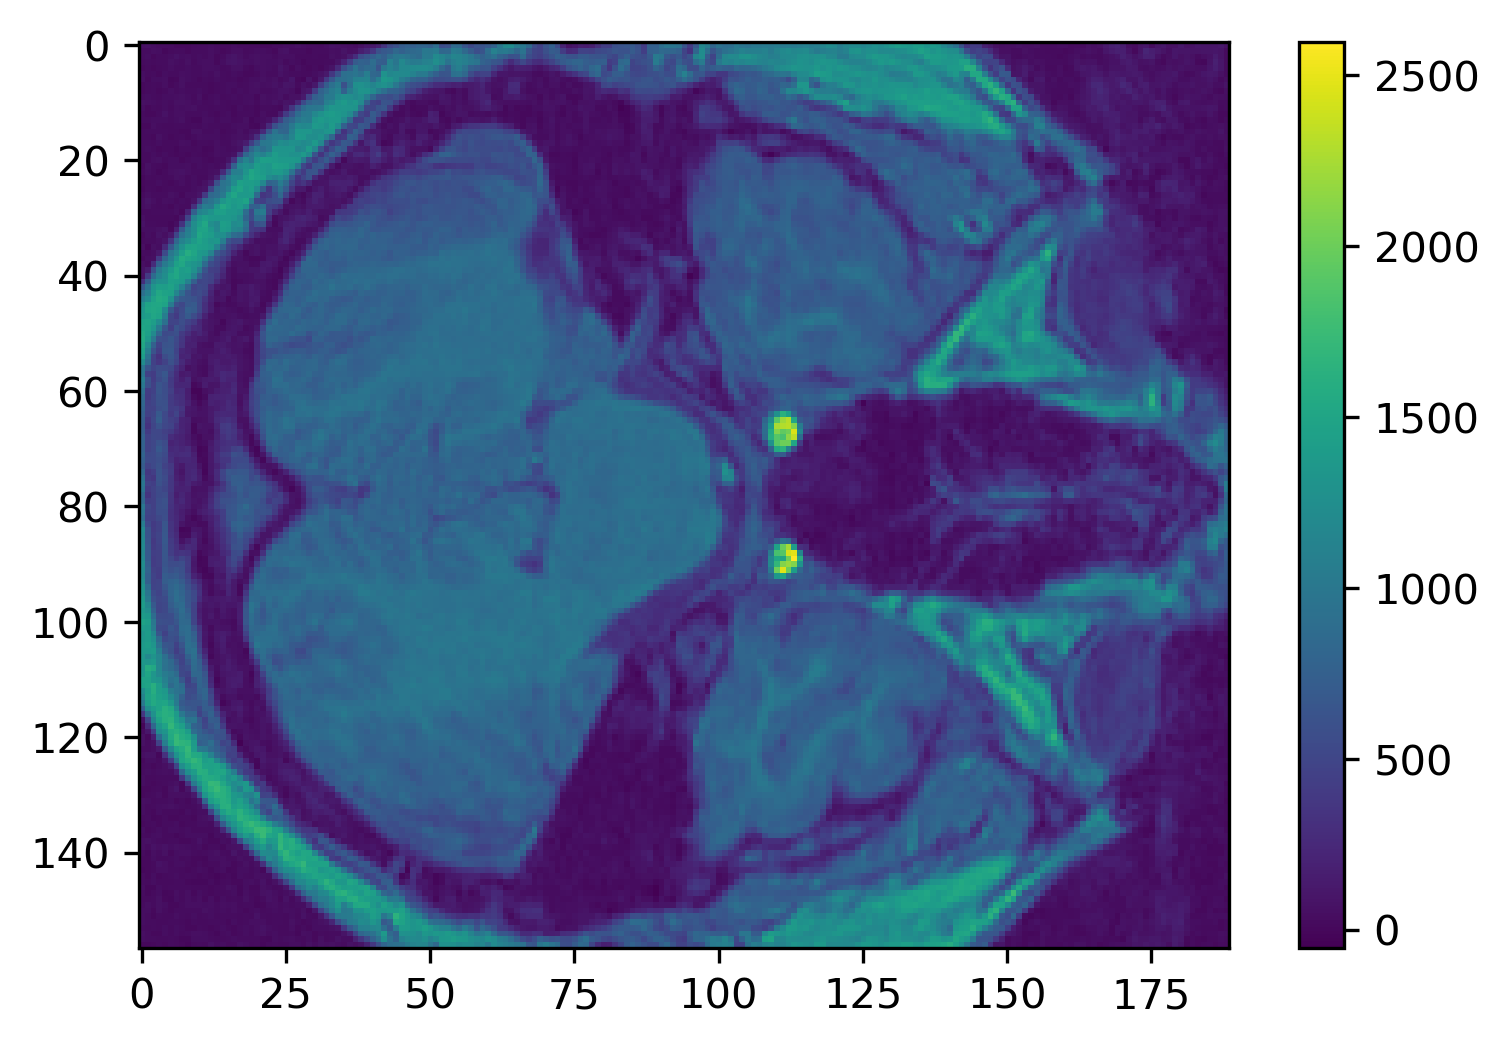

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(dpi=300)
plt.imshow(arr[:,:,5])
plt.colorbar()
plt.show()

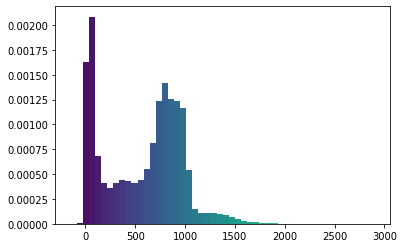

In [5]:
import numpy as np
from matplotlib import cm

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.viridis(c))

    plt.show()
    
show_histogram(arr)

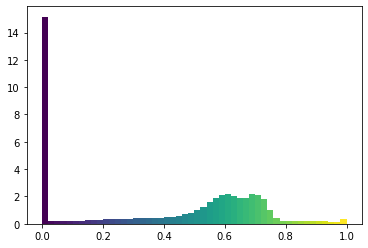

In [6]:
def scale_by(arr, fac):
    mean = np.mean(arr)
    return (arr-mean)*fac + mean

transformed = np.clip(scale_by(np.clip(normalize(arr)-0.1, 0, 1)**0.4, 2)-0.1, 0, 1)
show_histogram(transformed)

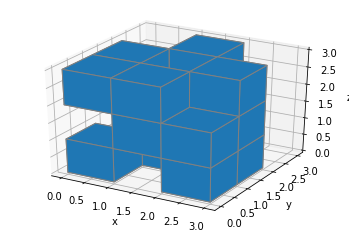

In [7]:
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

filled = np.array([
    [[1, 0, 1], [0, 0, 1], [0, 1, 0]],
    [[0, 1, 1], [1, 0, 0], [1, 0, 1]],
    [[1, 1, 0], [1, 1, 1], [0, 0, 0]]
])

ax = make_ax(True)
ax.voxels(filled, edgecolors='gray', shade=False)
plt.show()

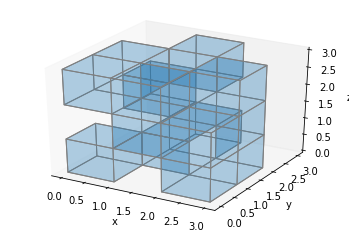

In [8]:
ax = make_ax()
ax.voxels(filled, facecolors='#1f77b430', edgecolors='gray', shade=False)
plt.show()

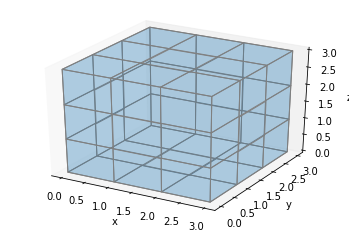

In [9]:
ax = make_ax()
ax.voxels(np.ones((3, 3, 3)), facecolors='#1f77b430', edgecolors='gray', shade=False)
plt.show()

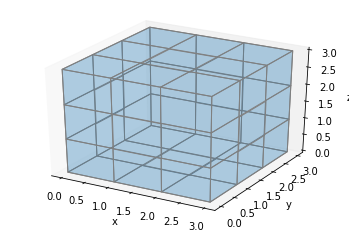

In [10]:
ax = make_ax()
colors = np.array([[['#1f77b430']*3]*3]*3)
colors[1,1,1] = '#ff0000ff'
ax.voxels(np.ones((3, 3, 3)), facecolors=colors, edgecolor='gray', shade=False)
plt.show()

In [11]:
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

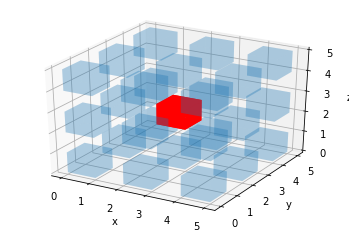

In [12]:
ax = make_ax(True)
colors = np.array([[['#1f77b430']*3]*3]*3)
colors[1,1,1] = '#ff0000ff'
colors = explode(colors)
filled = explode(np.ones((3, 3, 3)))
ax.voxels(filled, facecolors=colors, shade=False)
plt.show()

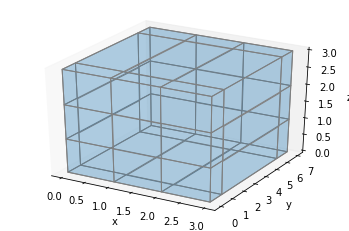

In [13]:
ax = make_ax()

filled = np.ones((3, 3, 3))
x, y, z = np.indices(np.array(filled.shape) + 1)
y[:,2:,:] += 4

ax.voxels(x, y, z, filled, facecolors='#1f77b430', edgecolor='gray', shade=False)
plt.show()

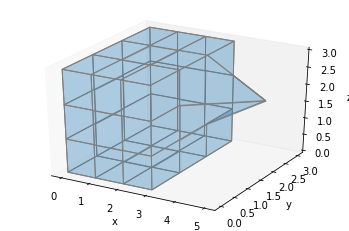

In [14]:
ax = make_ax()

filled = np.ones((3, 3, 3))
x, y, z = np.indices(np.array(filled.shape) + 1)
x[3, 2, 2] = 5

ax.voxels(x, y, z, filled, facecolors='#1f77b430', edgecolor='gray', shade=False)
plt.show()

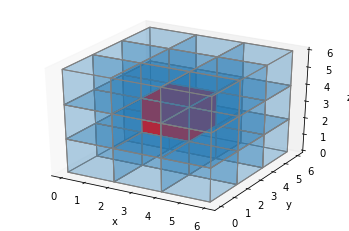

In [15]:
def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

ax = make_ax()
colors = np.array([[['#1f77b430']*3]*3]*3)
colors[1,1,1] = '#ff0000ff'
colors = explode(colors)
filled = explode(np.ones((3, 3, 3)))
x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))
ax.voxels(x, y, z, filled, facecolors=colors, edgecolors='gray', shade=False)
plt.show()

In [16]:
IMG_DIM = 50

from skimage.transform import resize
resized = resize(transformed, (IMG_DIM, IMG_DIM, IMG_DIM), mode='constant')

In [17]:
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    ax.set_axis_off()
    ax.set_facecolor('#404040')
    
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    plt.show()

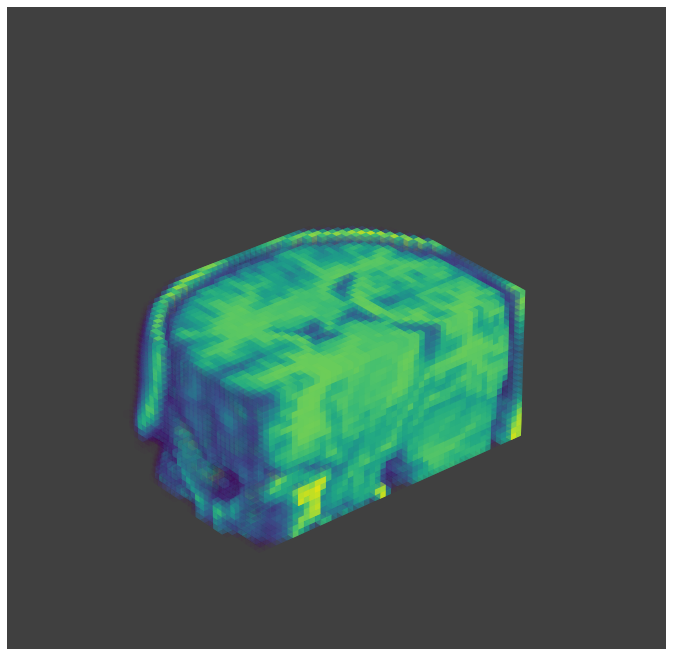

In [18]:
plot_cube(resized[:35,::-1,:25])

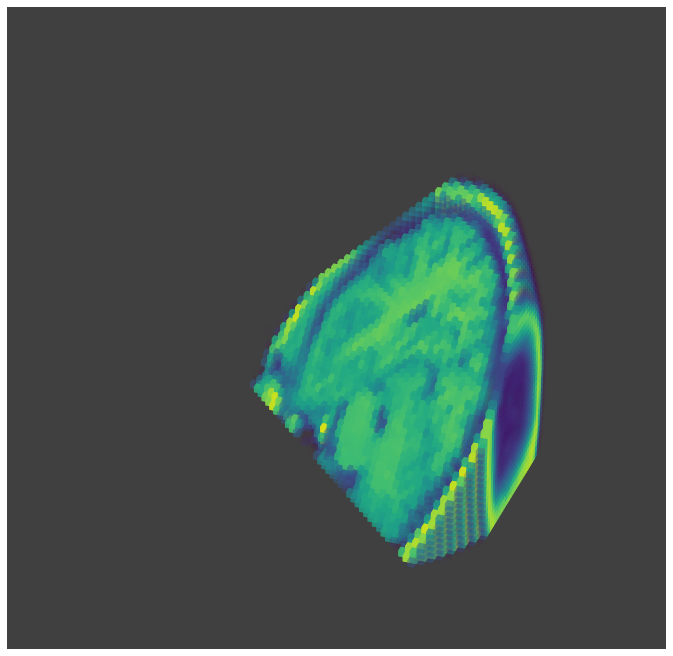

In [19]:
cube = np.copy(resized)

for x in range(0, IMG_DIM):
    for y in range(0, IMG_DIM):
        for z in range(max(x-y+5, 0), IMG_DIM):
            cube[x, y, z] = 0
plot_cube(cube, angle=200)

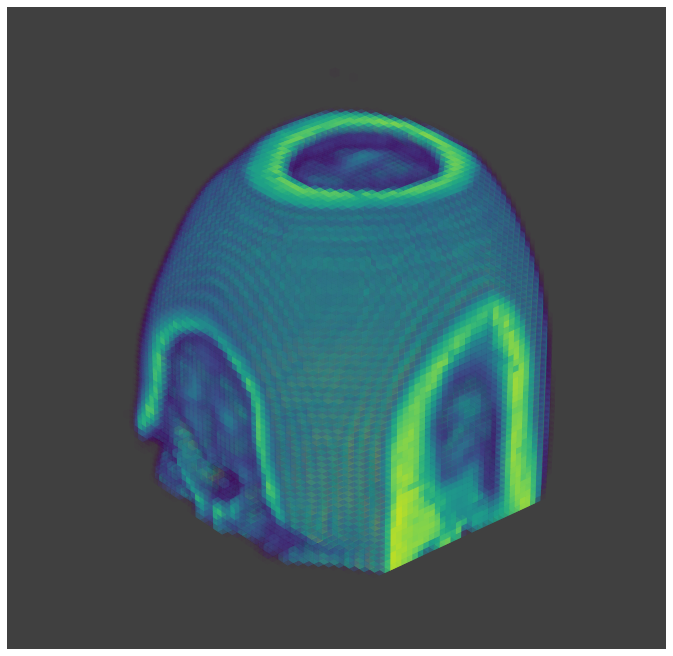

In [20]:
plot_cube(resized[:,::-1,:])